In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import T5Model
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments,  BertForPreTraining
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import nltk

/home/kalil/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Carrega dados de texto
data = pd.read_csv("all_ECB_speeches.csv", sep="|", encoding="utf-8")
print("Shape DataFrame: ", data.shape)
print("Data size: ", data.shape[0])
data_drop_nan = data.dropna(subset=data.columns)
data.dropna(subset=data.columns, inplace=True)
print("Dropando NaN")
print("Data size: ", data_drop_nan.shape[0] )
data.head()

Shape DataFrame:  (2772, 5)
Data size:  2772
Dropando NaN
Data size:  2683


,date,speakers,title,subtitle,contents
0,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",SPEECH European Parliament plenary debate ...
2,2024-02-16,Isabel Schnabel,From laggard to leader? Closing the euro area’...,Inaugural lecture of the EMU Lab by Isabel Sch...,SPEECH From laggard to leader? Closing the ...
4,2024-02-15,Christine Lagarde,Hearing of the Committee on Economic and Monet...,"Speech by Christine Lagarde, President of the ...",SPEECH Hearing of the Committee on Economic...
6,2024-02-14,Piero Cipollone,Preserving people’s freedom to use a public me...,"Introductory statement by Piero Cipollone, Mem...",SPEECH Preserving people’s freedom to ...
7,2024-02-14,Luis de Guindos,"Monetary policy, financial stability and mediu...","Speech by Luis de Guindos, Vice-President of t...","SPEECH Monetary policy, financial stability..."


In [4]:
isabel_schnabel_data = data[data['speakers'] == 'Isabel Schnabel']
isabel_schnabel_data.head()


,date,speakers,title,subtitle,contents
2,2024-02-16,Isabel Schnabel,From laggard to leader? Closing the euro area’...,Inaugural lecture of the EMU Lab by Isabel Sch...,SPEECH From laggard to leader? Closing the ...
34,2023-11-02,Isabel Schnabel,The last mile,"Keynote speech by Isabel Schnabel, Member of t...",SPEECH The last mile Keynote speech by Is...
46,2023-09-25,Isabel Schnabel,Money and inflation,"Thünen Lecture by Isabel Schnabel, Member of t...",SPEECH Money and inflation Thünen Lecture...
52,2023-09-05,Isabel Schnabel,What is special about climate-related and envi...,"Introductory remarks by Isabel Schnabel, Membe...",SPEECH What is special about climate-relate...
56,2023-08-31,Isabel Schnabel,Disinflation and the Phillips curve,"Speech by Isabel Schnabel, Member of the Execu...",SPEECH Disinflation and the Phillips curve ...


In [5]:
# Uso do dicionário de sentimentos NRC
#Cria um dicionário com as palavras positivas e um com as negativas

negative_dict = {}

with open("negative-NRC-Emotion-Lexicon.txt", "r") as file:
    for line in file:
        key, value = line.strip().split("\t")
        if value != "0":
            negative_dict[key] = int(value)

print(negative_dict)

positive_dict = {}

with open("positive-NRC-Emotion-Lexicon.txt", "r") as file:
    for line in file:
        key, value = line.strip().split("\t")
        if value != "0":
            positive_dict[key] = int(value)
            
# Uso do dicionário de sentimentos MCLou

filepath = 'mclou.csv'
mclou = pd.read_csv(filepath, sep=';', encoding='utf-8')

mclou_dict = {str(mclou['Word'][i]).lower(): [mclou['Positive'][i], mclou['Negative'][i]] for i in range(len(mclou))}
for key, value in mclou_dict.items():
    if mclou_dict[key][0] != 0:
        mclou_dict[key][0] = 1
    if mclou_dict[key][1] != 0:
        mclou_dict[key][1] = 1

for i in range(10):
    print(mclou['Word'][i], mclou['Positive'][i], mclou['Negative'][i])
    print(mclou_dict[str(mclou['Word'][i]).lower()])

{'dementia': 1, 'elimination': 1, 'pathetic': 1, 'lower': 1, 'gasping': 1, 'leech': 1, 'detritus': 1, 'suspension': 1, 'outhouse': 1, 'hobo': 1, 'addiction': 1, 'onus': 1, 'incomprehensible': 1, 'scarcity': 1, 'torture': 1, 'bigoted': 1, 'infiltration': 1, 'inefficient': 1, 'chafing': 1, 'enigmatic': 1, 'payment': 1, 'perversion': 1, 'evacuation': 1, 'hangman': 1, 'turbulence': 1, 'rat': 1, 'strike': 1, 'carnal': 1, 'confined': 1, 'egotistical': 1, 'freezing': 1, 'declination': 1, 'presentment': 1, 'subsidence': 1, 'carelessness': 1, 'clump': 1, 'spurious': 1, 'nihilism': 1, 'resigned': 1, 'prodigal': 1, 'fruitless': 1, 'slaughterhouse': 1, 'income': 1, 'disapproving': 1, 'confiscate': 1, 'poorly': 1, 'clouded': 1, 'poverty': 1, 'screwed': 1, 'crisp': 1, 'horrific': 1, 'injury': 1, 'unhappy': 1, 'sorely': 1, 'harass': 1, 'gap': 1, 'hypocritical': 1, 'havoc': 1, 'dagger': 1, 'lonely': 1, 'rekindle': 1, 'decrepit': 1, 'misrepresent': 1, 'remorse': 1, 'whore': 1, 'ulterior': 1, 'woefully'

In [6]:
# Função para calcular o sentimento de um texto usando os dicionários MCLou e NRC
# Se a palavra estiver em um dos dicionários, ela é incrementada como positiva ou negativa
# Se a palavra não estiver em nenhum dos dicionários, ela é incrementada como neutra
# Se a palavra estiver nos dois dicionários, ela pode ser incrementada como positiva e/ou negativa

def get_sentiment_double(text, emo_score):
    text = text.split()
    positive_score = 0
    negative_score = 0
    neutral_score = 0
    last_emo = [0, 0, 1]
    for word in text:
        word = word.lower()
        if word in mclou_dict:
            if word in positive_dict or mclou_dict[word][0] != 0:
                if last_emo != [1, 0, 0]:
                  positive_score += 1
                  last_emo = [1, 0, 0]
            if word in negative_dict or mclou_dict[word][1] != 0:
                if last_emo != [0, 1, 0]:
                  negative_score += 1
                  last_emo = [0, 1, 0]
            if (mclou_dict[word][0] == 0 and mclou_dict[word][1] == 0) or (word not in positive_dict and word not in negative_dict):
                if last_emo != [0, 0, 1]:
                  neutral_score += 1
                  last_emo = [0, 0, 1]
        elif word in positive_dict:
            if last_emo != [1, 0, 0]:
              positive_score += 1
              last_emo = [1, 0, 0]
        elif word in negative_dict:
            if last_emo != [0, 1, 0]:
              negative_score += 1
              last_emo = [0, 1, 0]
        else:
            if last_emo != [0, 0, 1]:
              neutral_score += 1
              last_emo = [0, 0, 1]
    score = [positive_score, negative_score, neutral_score]
    # print(score)
    for i in range(len(score)):
        score[i] = max(0, score[i] + 1 - max(score))
    # print(score)
    emo_score.append(score)

    if positive_score > negative_score and positive_score > neutral_score:
        return "positive", emo_score
    elif positive_score < negative_score and negative_score > neutral_score:
        return "negative", emo_score
    else:
        return "neutral", emo_score

In [3]:
# Inicia o modelo BERT para classificação de texto
model = BertForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3)
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")
labels = model.config.id2label

/home/kalil/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
target = isabel_schnabel_data['contents']
print(target.shape)

(55,)


In [10]:
for un in data['speakers'].unique():
    target = data[data['speakers'] == un]['contents']
    print("Speaker: ", un)
    emo_dict_score = []
    with open("dict.txt", "a") as file:
        file.write("Speaker: " + un + "\n")
    for exemplo in target:
        exemplo = exemplo.split(",")
        exemplo = np.array(exemplo)
        index = np.random.randint(0, len(exemplo), 10)
        sum_states = []
        for sentence in exemplo:
            sent, sum_states = get_sentiment_double(sentence, sum_states)
        sum_states = np.sum(sum_states, axis=0)
        emo_dict_score.append(sum_states)
        with open("dict.txt", "a") as file:
            file.write(str(sum_states) + "\n")
        # with torch.no_grad():
        #     inputs = tokenizer(target, return_tensors="pt", padding=True, truncation=True)
        #     outputs = model(**inputs)
        #     logits = outputs.logits
        #     predictions = torch.argmax(logits, dim=-1)
        #     print("Sentiment: ", labels[predictions[0].item()])

Speaker:  Christine Lagarde
Speaker:  Isabel Schnabel
Speaker:  Piero Cipollone
Speaker:  Luis de Guindos
Speaker:  Philip R. Lane
Speaker:  Frank Elderson
Speaker:  Fabio Panetta
Speaker:  Yves Mersch
Speaker:  Benoît Cœuré
Speaker:  Sabine Lautenschläger
Speaker:  Mario Draghi
Speaker:  Peter Praet
Speaker:  Vítor Constâncio
Speaker:  Jörg Asmussen
Speaker:  José Manuel González-Páramo
Speaker:  Lorenzo Bini Smaghi
Speaker:  Jürgen Stark
Speaker:  Jean-Claude Trichet
Speaker:  Gertrude Tumpel-Gugerell
Speaker:  Lucas Papademos
Speaker:  Otmar Issing
Speaker:  Tommaso Padoa-Schioppa
Speaker:  Eugenio Domingo Solans
Speaker:  Willem F. Duisenberg
Speaker:  Sirkka Hämäläinen
Speaker:  Christian Noyer
Speaker:  Willem F. Duisenberg,Eugenio Domingo Solans
Speaker:  Alexandre Lamfalussy


In [7]:

last = "Frank Elderson"
num = 18
write = False
for un in data['speakers'].unique():
    target = data[data['speakers'] == un]['contents']
    print(un)
    emo_bert_score = []
    item = 0
    if un == last or write:
        with open("new_bert.txt", "a") as file:
            file.write("Speaker: " + un + "\n")
        for exemplo in target:
            if num <= item or write:
                exemplo = exemplo.split(",")
                exemplo = np.array(exemplo)
                index = np.random.randint(0, len(exemplo), 10)
                sum_states = []
                # print(exemplo[0], "ggggggg")
                for sentence in exemplo:
                    index_2 = np.random.randint(0, len(sentence), 10)
                    inputs = tokenizer(sentence, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
                    outputs = model(**inputs)
                    sum_states.append(np.array(outputs[0].tolist()))
                # sum_states = np.sum(sum_states, axis=0)
                for i in range(len(sum_states)):
                    sum_states[i] = np.argmax(sum_states[i])
                pos = sum_states.count(0)/len(sum_states)
                neg = sum_states.count(1)/len(sum_states)
                neu = sum_states.count(2)/len(sum_states)
                emo_bert_score.append([pos, neg, neu])
                # prediction = labels[np.argmax(sum_states)]
                file = open("new_bert.txt", "a")
                file.write(str(emo_bert_score[item]) + "\n")
                file.close()
                item += 1
        write = True
    
# emo_dict_score = []
# for exemplo in target:
#   exemplo = exemplo.split(",")
#   exemplo = np.array(exemplo)
#   index = np.random.randint(0, len(exemplo), 10)
#   sum_states = []
#   for sentence in exemplo:
#     sent, sum_states = get_sentiment_double(sentence, sum_states)
#   sum_states = np.sum(sum_states, axis=0)
#   emo_dict_score.append(sum_states)
#   # prediction = labels[np.argmax(sum_states)]
#   if sum_states[0] > sum_states[1] and sum_states[0] > sum_states[2]:
#     prediction = "positive"
#   elif sum_states[1] > sum_states[0] and sum_states[1] > sum_states[2]:
#     prediction = "negative"
#   else:
#     prediction = "neutral"
  

# for word in emo_bert_score:
#   file = open("bert.txt", "a")
#   file.write(str(word) + "\n")
#   file.close()

# for word in emo_dict_score:
#   file2 = open("dict.txt", "a")
#   file2.write(str(word) + "\n")
#   file2.close()
  

Christine Lagarde
Isabel Schnabel
Piero Cipollone
Luis de Guindos
Philip R. Lane
Frank Elderson
Fabio Panetta


KeyboardInterrupt: 

In [ ]:
import multiprocessing

def worker_function(item, shared_list):
    try:
        # Perform some computation or task
        result = item * 2
        # Access the shared list using the manager
        shared_list.append(result)
        return result, None  # Return result and no exception
    except Exception as e:
        return None, e  # Return None as result and the exception

if __name__ == '__main__':
    # Create a manager to manage the shared list
    manager = multiprocessing.Manager()
    shared_list = manager.list(range(10))
    
    # Create a pool of workers
    pool = multiprocessing.Pool()
    
    # Define the items to process
    items = [1, 2, 3, 4, 5]
    
    # Process the items in parallel
    results = []
    print("Processing items in parallel...")
    for item in items:
        result = pool.apply_async(worker_function, args=(item, shared_list))
        results.append(result)
    print("Waiting for all processes to complete...")
    # Wait for all processes to complete and check for exceptions
    for result in results:
        print("Result:")
        res, error = result.get()
        print(res)
        if error:
            print("Error occurred in one of the worker processes:", error)
    print("All processes completed.")
    # Print the shared list
    print("Shared list:", shared_list)
    
    pool.close()
    pool.join()


Processing items in parallel...
Waiting for all processes to complete...
Result:


In [4]:
import numpy as np
from multiprocessing import Pool

def process_example(exemplo):
    exemplo = exemplo.split(",")
    exemplo = np.array(exemplo)
    index = np.random.randint(0, len(exemplo), 10)
    sum_states = []
    for sentence in exemplo:
        index_2 = np.random.randint(0, len(sentence), 10)
        inputs = tokenizer(sentence, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
        outputs = model(**inputs)
        sum_states.append(np.array(outputs[0].tolist()))
    sum_states = np.sum(sum_states, axis=0)
    return sum_states

if __name__ == '__main__':
    for un in data['speakers'].unique():
        target = data[data['speakers'] == un]['contents']
    
        emo_bert_score = []
        target_slice = target  # Assuming target is your list of examples
        with Pool() as pool:
            emo_bert_score = pool.map(process_example, target_slice)

        with open("big_bert.txt", "a") as file:
            file.write("Speaker: " + un + "\n")
            for item in emo_bert_score:
                file.write(str(item) + "\n")


In [14]:
for un in data['speakers'].unique():
    with open("sizes.txt", "a") as file:
        file.write("Speaker: " + un + "\n")
    target = data[data['speakers'] == un]
    sizes = []
    for exemplo in target["contents"]:
        exemplo = exemplo.split(",")
        sizes.append(len(exemplo))
    print(sizes)
    # packages = [
    #     "absl-py==1.4.0",
    #     "aiofiles==22.1.0",
    #     "aiohttp==3.9.3",
    #     # Add the rest of the packages here
    # ]

    with open("sizes.txt", "a") as file:
        for size in sizes:
            file.write(str(size) + "\n")
            
    with open("dates.txt", "a") as file:
        file.write("Speaker: " + un + "\n")
    date = []
    for exemplo in target["date"]:
        date.append(exemplo)

    with open("dates.txt", "a") as file:
        for d in date:
            file.write(str(d) + "\n")


# emo_dict_score = []
# # print(isabel_schnabel_data["date"])
# with open("dict.txt", "r") as file:
#     texto = file.readlines()
# ite = 0
# for linha in texto:
#     v = linha.split(" ")
#     # print(v)
#     vl = [float(v[0][1:]), float(v[1]), float(v[2][:-2])]
#     # print(vl)
#     emo_dict_score.append(vl)

# print(emo_dict_score)

# emo_bigbert_score = []
# with open("big_bert.txt", "r") as file:
#     texto = file.readlines()
# ite = 0
# for linha in texto:
#     v = linha.split(" ")
#     print(v)
#     try:
#         vl = [float(v[0][1:]), float(v[1]), float(v[2][:-2])]
#     except:
#         print(v)
#         print(v[0][2:])
#         print(v[1])
#         print(v[2][:-2])
#         raise
#     # print(vl)
#     emo_bigbert_score.append(vl)

# print(emo_bigbert_score)

# emo_bert_score = []
# with open("bert.txt", "r") as file:
#     texto = file.readlines()
# ite = 0
# for linha in texto:
#     v = linha.split(" ")
#     print(v)
#     vl = [float(v[0][1:]), float(v[1]), float(v[2][:-2])]
#     print(vl)
#     emo_bert_score.append(vl)

# print(emo_bert_score)

[106, 73, 236, 95, 78, 91, 188, 54, 43, 87, 34, 122, 79, 243, 277, 436, 116, 141, 49, 30, 65, 150, 113, 138, 203, 99, 176, 70, 79, 78, 116, 114, 89, 193, 53, 200, 78, 59, 216, 174, 52, 108, 180, 316, 80, 132, 221, 28, 102, 40, 85, 129, 38, 97, 296, 194, 188, 124, 83, 210, 311, 80, 113, 94, 366, 94, 54, 45, 131, 113, 135, 94, 74, 111, 63, 82, 219, 253, 81, 198, 98, 87, 348, 101, 103, 134, 120, 108, 85, 46, 55, 102, 61, 91, 121, 57, 99, 106, 43, 131, 68]
[647, 258, 706, 160, 326, 379, 426, 302, 472, 261, 363, 267, 258, 479, 281, 297, 217, 238, 199, 279, 299, 228, 463, 316, 246, 229, 110, 201, 418, 251, 305, 357, 229, 297, 220, 384, 282, 329, 67, 445, 304, 286, 341, 95, 273, 296, 289, 284, 219, 203, 135, 196, 162, 431, 246]
[169, 333, 194, 136]
[112, 63, 71, 43, 64, 122, 217, 214, 42, 122, 57, 83, 170, 70, 80, 81, 78, 65, 79, 51, 63, 95, 78, 112, 88, 154, 88, 110, 148, 67, 46, 81, 75, 78, 94, 70, 97, 108, 84, 39, 90, 102, 121, 173, 114, 56, 118, 78, 118, 14, 118, 140, 52, 163, 48, 242, 14

In [ ]:
def invert_list(lista):
    lista = np.array(lista)
    lista = np.transpose(lista)
    return lista
# print(emo_dict_score)
# emo_dict_score = invert_list(emo_dict_score)
# print(emo_dict_score)
# print(emo_bigbert_score)
# emo_bigbert_score = invert_list(emo_bigbert_score)
print(emo_bigbert_score)
# emo_bert_score = invert_list(emo_bert_score)

def normalize(array):
    array = np.array(array)
    array = array / np.max(array)
    return array

[[-288.7776969, -513.91392101, 1112.46107631], [-139.99001825, -78.19944296, 332.80887216], [-421.02554335, -485.86597752, 1304.60290125], [-108.53562262, -111.86791553, 320.87196958], [-161.71200131, -84.32754607, 380.77790156], [-209.58787286, -120.35695932, 513.69157879], [-168.7517898, -317.71406329, 656.6619055], [-134.66177998, -226.66120044, 499.71005983], [-234.21589031, -345.5781805, 807.84649028], [-75.52431939, -253.18456127, 440.34446828], [-150.28176236, -209.68423107, 515.17614926], [-152.77395079, -61.53132552, 340.826387], [-144.4302966, -209.67850215, 506.60140114], [-272.02193721, -290.27840236, 850.71558595], [-118.76920784, -214.0393037, 456.4525416], [-76.7833837, -212.41087902, 384.44972761], [-36.07135525, -121.76124247, 211.88263687], [-72.24155735, -201.72704867, 369.03137536], [-18.06886707, -151.24863607, 204.78648247], [-79.64426457, -213.19834972, 398.47403899], [-136.1136852, -193.81852409, 468.96738309], [-61.66562773, -110.22325086, 236.1311738], [-267.5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 5, 5, 5, 3, 3, 5, 3, 3, 3, 3, 5, 5, 3, 5, 5, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 3, 3]


C:\Users\Superalien10\AppData\Local\Temp\ipykernel_17700\518321418.py:57: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


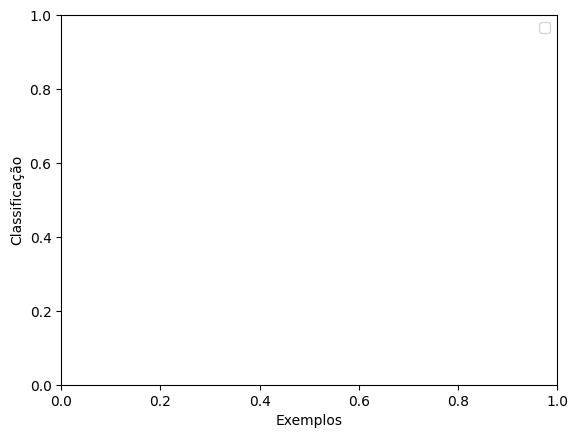

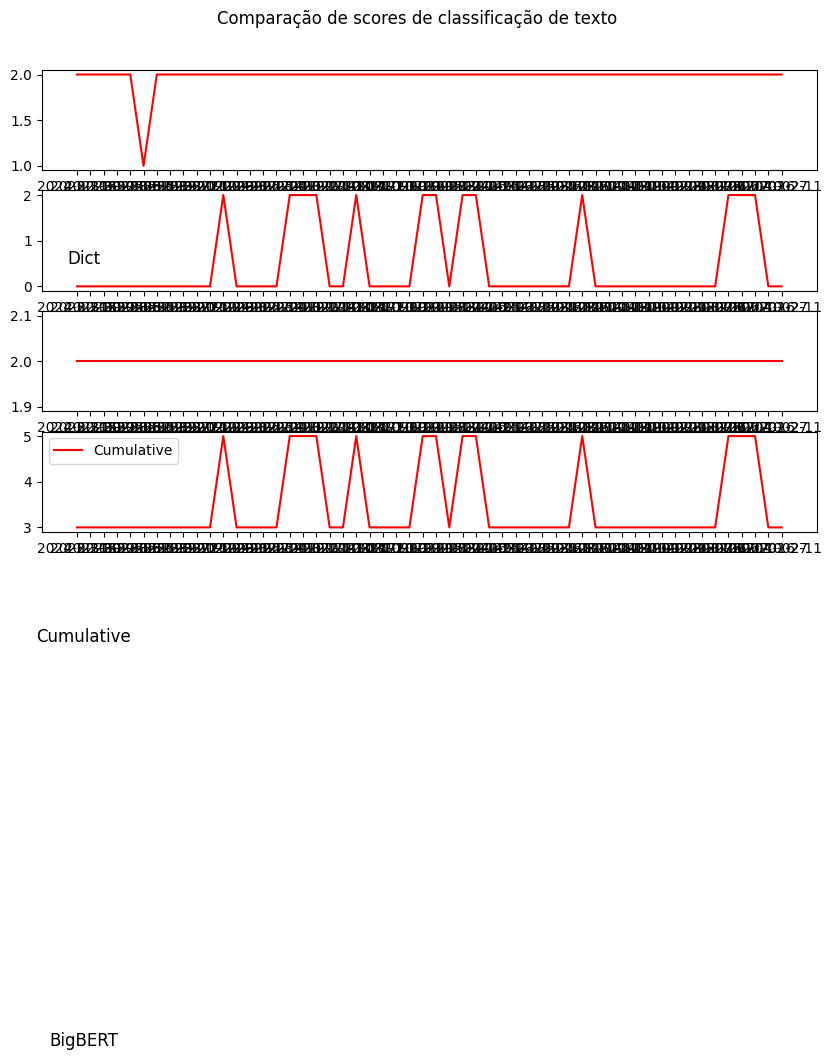

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Dados de exemplo
exemplos = target

# Criar figura e eixos
fig, ax = plt.subplots()

# Definir rótulos dos eixos
ax.set_xlabel('Exemplos')
ax.set_ylabel('Classificação')

# Adicionar legenda
ax.legend()

# Exibir o gráfico
import matplotlib.pyplot as plt

# Extract the scores from emo_bert_score and emo_dict_score
# bert_scores = [normalize(score) for score in emo_bert_score]
bert_scores = [np.argmax(score) for score in emo_bert_score]
# print(bert_scores)
print(bert_scores)
dict_scores = [np.argmax(score) for score in emo_dict_score]
# dict_scores = normalize(dict_scores)
print(dict_scores)
bigbert_scores = [np.argmax(score) for score in emo_bigbert_score]
# bigbert_scores = normalize(bigbert_scores)
print(bigbert_scores)
cumulative_scores = [np.argmax(emo_bert_score[i] + emo_dict_score[i]) for i in range(len(emo_bert_score))]
# cumulative_scores = normalize(cumulative_scores)
print(cumulative_scores)

# Create the x-axis values (examples)
# examples = range(len(bert_scores))
examples = isabel_schnabel_data["date"]
examples = np.transpose(examples)

fig, axes = plt.subplots(4, 1, figsize=(10, 6))

data = [bert_scores, dict_scores, bigbert_scores, cumulative_scores]
labels = ['BERT', 'Dict', 'BigBERT', 'Cumulative']

for i, ax in enumerate(axes):
    ax.plot(examples, data[i], label=labels[i], color='red')
    ax.text(0.5, 0.5, labels[i], fontsize=12, ha='center')
# plt.text(0.05, 0.8, 'Score agregado', fontsize=12, ha='center', orientation='vertical')
# plt.text(01.2, 0.1, 'Score agregado', fontsize=12, ha='center')
# plt.supxlabel('Tempo')
# plt.supylabel('Score agregado')
plt.xticks
plt.suptitle('Comparação de scores de classificação de texto')

# Add a legend
plt.legend()
plt.tight_layout()

# Show the graph
plt.show()

